In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# import sys
# sys.path.append('../tools')

In [3]:
import timm
import pandas as pd
import numpy as np
# from tqdm.notebook import tqdm
from madgrad import MADGRAD
# from fastai.vision.all import *
from tools.train_utils import *
# from train_utils import *

In [4]:


class CONF( ConfigClass):
    arcface_s = 30.0
    n_epoch = 5
    start_m = 0.2
    end_m = 0.3
    bs = 32
    size = 224
    split_nfnet=0
    embedding_size=1024
    experiment_id=1
    OUTPUT_CLASSES= 11014
    debug = True

conf = CONF()

In [5]:
base_path = 'data'
# base_path = '../data'
conv_layer = 'adaptconcat_lin'
saved_folder = base_path + '/saved_models/image_model/'
saved_name  = f'{conf.n_epoch}epoch_nfnetl0-bs-{conf.bs}-mgrad-{conv_layer}-embed-{conf.embedding_size}-m{(int(conf.start_m*10)):02d}-{int(conf.end_m)*10}'
image_path = base_path + '/train_images/'

In [6]:
class ArcFaceNet(nn.Module):
    def __init__(self, arch, embedding_size=512, classifier=None):
        super().__init__()
        self.body = create_body(arch, cut=-2)
        nf = num_features_model(nn.Sequential(*self.body.children()))      
        self.after_conv=nn.Sequential(
                AdaptiveConcatPool2d(),
                Flatten(),
                nn.Linear(nf*2,embedding_size),
                nn.BatchNorm1d(embedding_size)
            )       

        self.classifier = classifier if classifier is not None else None
    def forward(self, x):
        x = self.body(x)
        embeddings = self.after_conv(x)
        return self.classifier(embeddings)


In [14]:


train_df = add_splits(pd.read_csv(base_path + '/train.csv'))
valid_df = train_df[train_df.is_valid==True].copy()
train_df.is_valid=False
if conf.debug:
    train_df = train_df[train_df.split==0]
    train_df.is_valid=False
    # train_df = train_df[:conf.bs * 3]
    # valid_df = valid_df[:conf.bs * 3]

train_df= pd.concat([train_df, valid_df])
labels = train_df.label_group.unique()


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [8]:
len(labels)

2203

In [9]:
train_df.head()

,posting_id,image,image_phash,title,label_group,split,is_valid
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,0,True
11,train_2496690777,001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET,509010932,0,True
12,train_2771755203,001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET PART 2,509010932,0,True
15,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsShop SP LC,349297863,0,True
21,train_2238403912,003524b70715bf6bfa00451ca08e66e0.jpg,ba35c44a3fb7c068,Kangaroo Teflon / Allu Fry Pan 18 cm - KG652,531768918,0,True


In [10]:
# model.load_state_dict(torch.load( saved_folder +  saved_name))
# model.classifier = classifier

In [15]:

arch = timm.create_model("eca_nfnet_l0", pretrained = False)
classifier = ArcFaceClassifier(in_features=conf.embedding_size)
model = ArcFaceNet(arch = arch, embedding_size=conf.embedding_size, classifier=classifier)

loss_func = ArcFaceLossFlat(m=conf.start_m)
opt_func = partial(OptimWrapper, opt=MADGRAD)
dls = get_image_dls(train_df, 
                    path=image_path,
                    valid_col=train_df.columns.get_loc("is_valid"),
                    size= conf.size,
                    bs=conf.bs
                    )
if conf.split_nfnet:
    split_func= split_nfnet
else:
    split_func = split_2way


In [ ]:
# arch = timm.create_model("eca_nfnet_l0", pretrained = True)
# classifier = ArcFaceClassifier(in_features=conf.embedding_size)
# model = ArcFaceNet(arch = arch, embedding_size=conf.embedding_size, classifier=classifier)

In [ ]:
# learn.load('stage1-fine_tune_3epoch_nfnetl1-bs-64-pre-mgrad-gdconv-embed-1024-m03-10')

In [ ]:
print('Starting', conf.experiment_id)
print(conf)


Starting 1
{'OUTPUT_CLASSES': 11014, 'arcface_s': 30.0, 'bs': 32, 'debug': True, 'embedding_size': 1024, 'end_m': 1.0, 'experiment_id': 1, 'n_epoch': 5, 'size': 224, 'split_nfnet': 0, 'start_m': 0.8}


In [16]:
learn = Learner(dls=dls,
                model=model,
                splitter=split_func, 
                opt_func=opt_func,
                loss_func=loss_func, 
                cbs = [ 
                        CutMix, 
                        GradientClip,
                        MixedPrecision, 
                        MarginScheduler(conf.start_m, conf.end_m)
                    ],
                metrics=[accuracy, F1Score(average='weighted')]
                )

# if conf.gradient_clip:
#     learn.cbs.append(GradientClip)

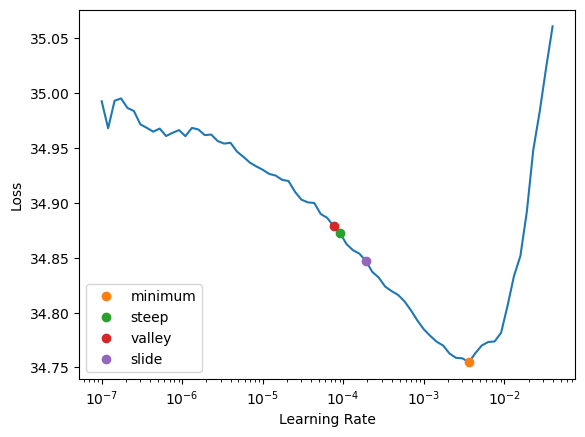

In [12]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [13]:
lr_steep

9.120108734350652e-05

In [ ]:
learn.fine_tune(conf.n_epoch,base_lr=9.120108734350652e-05)


In [ ]:
# %debug

In [ ]:
# learn.save('stage1-'+ saved_name)

In [ ]:

# print('saving',f'model' )
# torch.save(learn.model.state_dict(), saved_folder +  saved_name + '_w_classifier.pth')
# save_without_classifier(learn.model, saved_folder +  saved_name + '_wo_classifier.pth')